In [1]:
import sys
sys.path.append("../")

In [2]:
from data_tools.containers import StocksData, StocksTarget
from data_tools.model_preprocessors import SimpleModelPreprocessor
from targets.target_function import ClosePriceTargetFunction
from models import GBMRegressionModel
from features import IndicatorsFeaturesList

import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

c:\ProgramData\Anaconda3\envs\trading-algorithms\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Firstly, we need to read the data and add features to it. `StocksData` class is responsible for reading the stock data from file. `FeaturesList` class contains list of features which can be added to our AAPL data.

In [3]:
stocks_data = StocksData(files=["../data/market_data/AAPL.csv"])
stocks_data = IndicatorsFeaturesList().preprocess(stocks_data)
stocks_data.dates_range()

(Timestamp('2021-01-25 14:30:00'), Timestamp('2023-01-12 21:00:00'))

Let's check internal DataFrame.

In [4]:
stocks_data.get_data().head()

,high,low,open,close,volume,ticker,close_5_mean,close_10_mean,close_20_mean,open_5_mean,...,open_20_median,high_5_median,high_10_median,high_20_median,low_5_median,low_10_median,low_20_median,volume_5_median,volume_10_median,volume_20_median
date,,,,,,,,,,,,,,,,,,,,,
2021-01-25 14:30:00,145.080002,142.940002,143.125000,144.229996,46354729.0,AAPL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25 15:30:00,144.320007,136.539993,144.229996,141.220001,37087128.0,AAPL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25 16:30:00,142.949997,140.910004,141.220001,141.190002,18948572.0,AAPL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25 17:30:00,143.289993,141.039993,141.179993,142.989899,14505566.0,AAPL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25 18:30:00,143.250000,141.789993,143.009995,142.582001,11219998.0,AAPL,142.44238,NaN,NaN,142.552997,...,NaN,143.289993,NaN,NaN,141.039993,NaN,NaN,18948572.0,NaN,NaN


Now, we need to define our targets. `Target` is a class which contains target data `StocksData`. It is created when we call `get` method of `TargetFunction` class. Also, you can create `Target` from its static method `from_target_function`.

In [5]:
stocks_target = StocksTarget.from_target_function(stocks_data, ClosePriceTargetFunction(bars_count=3))

In [6]:
stocks_target.get_data().head()

,close_target_3_bars,ticker
date,,
2021-01-25 14:30:00,142.989899,AAPL
2021-01-25 15:30:00,142.582001,AAPL
2021-01-25 16:30:00,142.070007,AAPL
2021-01-25 17:30:00,142.899994,AAPL
2021-01-25 18:30:00,142.212097,AAPL


At this moment we have to do final preprocessing step in order to prepare our data for training a model. We can do it with one of `StockDataModelPreprocessor` class inheritors. 

In [7]:
train_data, test_data, train_target, test_target = SimpleModelPreprocessor.split(stocks_data, stocks_target, threshold="2022-11-12")

preprocessor = SimpleModelPreprocessor()
X_train, y_train = preprocessor.preprocess(train_data, train_target, dropna=False, return_tensors=False)
X_test, y_test = preprocessor.preprocess(test_data, test_target, dropna=False, return_tensors=False)

In [8]:
train_data.dates_range(), test_data.dates_range()

((Timestamp('2021-01-25 14:30:00'), Timestamp('2022-11-11 20:30:00')),
 (Timestamp('2022-11-14 14:30:00'), Timestamp('2023-01-12 21:00:00')))

Finally, we can train our model and measure MAPE on the test sample.

In [9]:
model = GBMRegressionModel()
model.fit(X_train, y_train, verbose=False)

predictions = model.predict(X_test)

metric = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE: {metric}")

MAPE: 0.01271581514339898


Let's check the difference with simple constant predictor.

In [10]:
test_data.get_columns("close")

KeyError: "['c', 'l', 'o', 's', 'e'] not in index"

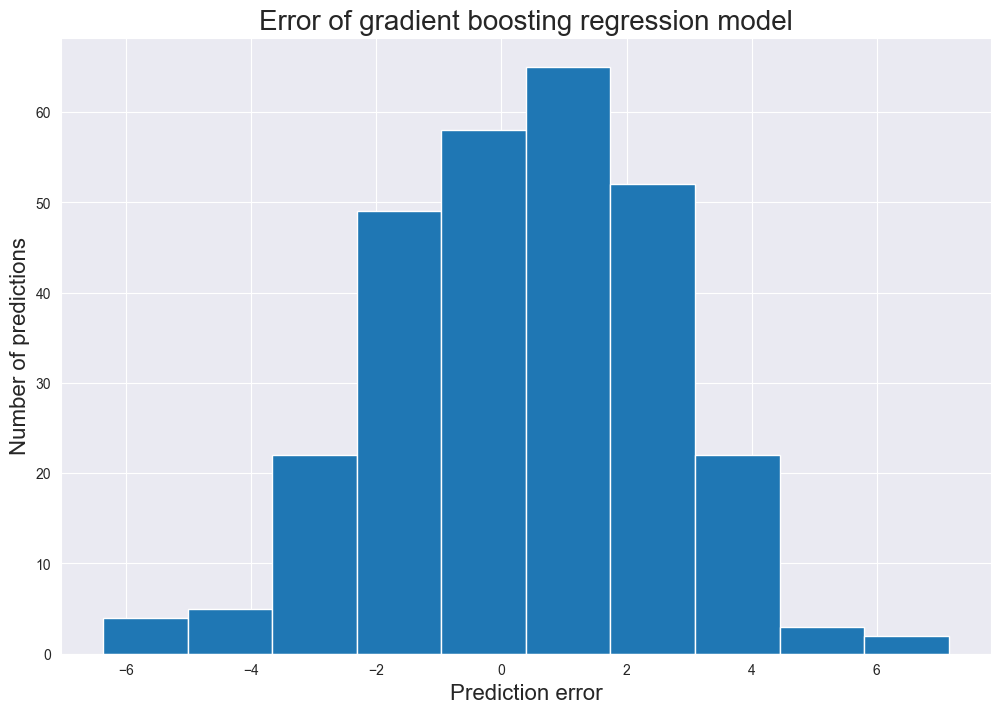

In [27]:
plt.figure(figsize=(12, 8))

error = predictions - y_test
plt.hist(error)

plt.title("Error of gradient boosting regression model", fontsize=20)
plt.xlabel("Prediction error", fontsize=16)
plt.ylabel("Number of predictions", fontsize=16)

plt.show()

In [61]:
percentile = np.quantile(np.abs(error), q=0.95)
mask = np.abs(error) >= percentile

worst_predictions = predictions[mask]
worst_errors_positions = np.where(mask)[0]

In [65]:
target_data[mask]

date
2022-11-14 18:30:00    153.169998
2022-11-29 14:30:00    140.535004
2022-11-30 15:30:00    146.294296
2022-11-30 16:30:00    147.080002
2022-11-30 17:30:00    148.029999
2022-12-12 18:30:00    148.089996
2022-12-14 17:30:00    143.220001
2022-12-14 18:30:00    138.870102
2022-12-14 19:30:00    138.249100
2022-12-14 20:30:00    137.899994
2022-12-15 14:30:00    136.964996
2022-12-21 20:30:00    130.789993
2022-12-30 20:30:00    124.660004
2023-01-06 18:30:00    132.565002
2023-01-06 19:30:00    133.085007
Name: close_target_3_bars, dtype: float64

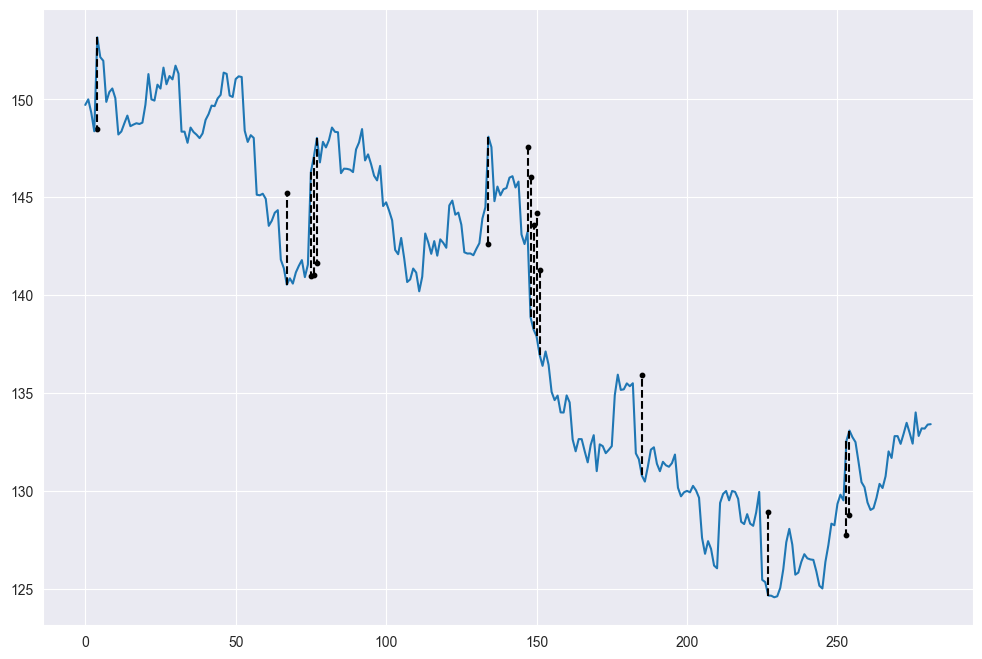

In [72]:
# Delete last 3 rows because target there is nan
target_data = test_target.get_data()["close_target_3_bars"][:-3]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(target_data)), target_data)
plt.scatter(worst_errors_positions, worst_predictions, color="black", s=10)
plt.vlines(worst_errors_positions, target_data[mask], worst_predictions, color="black", linestyles="dashed")

plt.show()